# Controlling Burgers' Equation with Reinforcement Learning
This notebook will present the results of using reinforcement learning to control Burgers' equation, a nonlinear PDE. The results are then compared to a supervised single-shooting method using the differentiable PDE solver [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow). The reinforcement learning method uses the framework [stable_baselines3](https://github.com/DLR-RM/stable-baselines3)

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../../'); sys.path.append('../envs'); sys.path.append('../../PDE-Control/PhiFlow'); sys.path.append('../../PDE-Control/src')
from phi.flow import *
from burgers_util import GaussianClash, GaussianForce
import matplotlib.pyplot as plt
import burgers_plots as bplt
import os

## Data Generation

In [2]:
domain = Domain([32], box=box[0:1])
viscosity = 0.003
step_count = 32
dt = 0.03
data_path = 'forced-burgers-clash'
scene_count = 1000
batch_size = 100
diffusion_substeps = 4

In [ ]:
for batch_index in range(scene_count // batch_size):
    scene = Scene.create(data_path, count=batch_size)
    print(scene)
    world = World()
    u0 = BurgersVelocity(domain, velocity=GaussianClash(batch_size), viscosity=viscosity, batch_size=batch_size, name='burgers')
    u = world.add(u0, physics=Burgers(diffusion_substeps=diffusion_substeps))
    force = world.add(FieldEffect(GaussianForce(batch_size), ['velocity']))
    scene.write(world.state, frame=0)
    for frame in range(1, step_count + 1):
        world.step(dt=dt)
        scene.write(world.state, frame=frame)

## Reinforcement Learning Initialization

In [3]:
from burgers_env import BurgersEnv
from vec_monitor import VecMonitor
from stable_baselines3 import PPO
from networks import RES_UNET, CNN_FUNNEL
from policy import CustomActorCriticPolicy

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWarning:

Passing (type, 1) or '1type' as a synony

In [4]:
test_range = range(100)
val_range = range(100, 200)
train_range = range(200, 1000)

n_envs = 8
final_reward_factor = step_count
steps_per_rollout = step_count * 100
training_timesteps = steps_per_rollout * 1

At first we have to create the environment the agent is to be trained in. 
The class `BurgersEnv` represents an environment, where random ground truth trajectories are generated on the fly. The environment is vectorized in that multiple trajectories are grouped together in batches during data generation.

In contrast to that, the `BurgersFixedSetEnv` describes environments that keep to a specific dataset. This is useful when trying to compare supervised and reinforcement learning methods on the same data.

The `VecMonitor` wrapper is used to log training stats to the console, and also to a file, if a path is specified

In [5]:
env = BurgersEnv(
    n_envs=n_envs,
    step_count=step_count,
    domain=domain,
    dt=dt,
    viscosity=viscosity,
    diffusion_substeps=diffusion_substeps,
    final_reward_factor=final_reward_factor,
)

# Wrap the environment in a monitor wrapper for logging
env = VecMonitor(
    venv=env,
    rollout_size=steps_per_rollout,
    filename=None,
    info_keywords=()
)

Next, we specify the deep learning agent. But wait, at first the network architectures as well as some hyperparameters have to be set.

The policy architecture is chosen according to the architecture described by Holl et al. TODO: CITATION
The value net consists of a convolutional network with max pooling layers to decrease resolution until 1x1 feature maps are left. In the end, these are processed by one linear layer to produce one output value.

In [8]:
ppo_kwargs = {
    'verbose': 1,
    'policy': CustomActorCriticPolicy,
    'policy_kwargs': {
        'pi_net': RES_UNET,
        'vf_net': CNN_FUNNEL,
        'vf_latent_dim': 16,
        'pi_kwargs': {
            'sizes': [4, 8, 16, 16, 16],
        },
        'vf_kwargs': {
            'sizes': [4, 8, 16, 16, 16],
        },
    },
    'n_steps': steps_per_rollout,
    'n_epochs': 10,
    'learning_rate': 1e-4,
    'batch_size': 128,
    'tensorboard_log': None,
}

In [9]:
agent = PPO(
    env=env,
    **ppo_kwargs,
)

Using cuda device


Now we are finally set up to start actually training the agent. The next line will take quite some time to execute, so grab a coffee and take your dog for a walk or something.

In [ ]:
agent.learn(total_timesteps=training_timesteps)

Alternatively, you could uncomment the below line to load a pretrained model

In [ ]:
#

Execute the cell below to store your trained model to disk.

In [10]:
agent_path = os.path.join("burgers-models", "agent")
os.mkdir('burgers-models')
agent.save(agent_path)

Now we can take a look at how the agent is performing:

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning:

Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



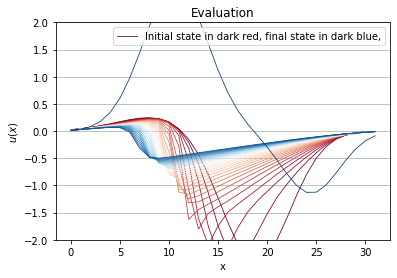

In [11]:
obs = env.reset()
bplt.burgers_figure('Evaluation')
plt.plot(obs[0][:,0], color=bplt.gradient_color(0, step_count+1), linewidth=0.8)
plt.legend(['Initial state in dark red, final state in dark blue,'])
plt.ylim(-2, 2)
for frame in range(1, step_count + 1):
    act, _ = agent.predict(obs, deterministic=True)
    obs, _, _, _ = env.step(act)
    plt.plot(obs[0][:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)

## CFE Chain Initialization

To classify the results of the reinforcement learning method, they are compared to a supervised control force estimator approach using a differentiable solver. This comparison seems natural as both algorithms work by optimizing through trial and error. While the CFE approach has the advantage of the differentiable solver, the reinforcement learning approach is not limited by training dataset size. However, this also introduces additional simulation overhead during training to generate the ground truth trajectories. This can increase training duration.

In [12]:
from control.pde.burgers import BurgersPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in 

In [13]:
cfe_app = ControlTraining(
    step_count,
    BurgersPDE(domain, viscosity, dt),
    datapath=data_path,
    val_range=val_range,
    train_range=train_range,
    trace_to_channel=lambda trace: 'burgers_velocity',
    obs_loss_frames=[],
    trainable_networks=['CFE'],
    sequence_class=StaggeredSequence,
    batch_size=100,
    view_size=20,
    learning_rate=1e-3,
    learning_rate_half_life=1000,
    dt=dt
).prepare()


App created. Scene directory is /home/felix/phi/model/control-training/sim_000060 (INFO), 2021-02-05 19:19:06,236n


Sequence class: <class 'control.sequences.StaggeredSequence'> (INFO), 2021-02-05 19:19:06,496n

Partition length 32 sequence (from 0 to 32) at frame 16
Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/struct/context.py:18: UserWarning:

struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.



Partition length 16 sequence (from 0 to 16) at frame 8


Partition length 8 sequence (from 0 to 8) at frame 4


Partition length 4 sequence (from 0 to 4) at frame 2


Partition length 2 sequence (from 0 to 2) at frame 1


Execute -> 1
Execute -> 2
Partition length 2 sequence (from 2 to 4) at frame 3


Execute -> 3
Execute -> 4
Partition length 4 sequence (from 4 to 8) at frame 6


Partition length 2 sequence (from 4 to 6) at frame 5


Execute -> 5
Execute -> 6
Partition length 2 sequence (from 6 to 8) at frame 7


Execute -> 7
Execute -> 8
Partition length 8 sequence (from 8 to 16) at frame 12


Partition length 4 sequence (from 8 to 12) at frame 10


Partition length 2 sequence (from 8 to 10) at frame 9


Execute -> 9
Execute -> 10
Partition length 2 sequence (from 10 to 12) at frame 11


Execute -> 11
Execute -> 12
Partition length 4 sequence (from 12 to 16) at frame 14


Partition length 2 sequence (from 12 to 14) at frame 13


Execute -> 13
Execute -> 14
Partition length 2 sequence (from 14 to 16) at frame 15


Execute -> 15
Execute -> 16
Partition length 16 sequence (from 16 to 32) at frame 24


Partition length 8 sequence (from 16 to 24) at frame 20


Partition length 4 sequence (from 16 to 20) at frame 18


Partition length 2 sequence (from 16 to 18) at frame 17


Execute -> 17
Execute -> 18
Partition length 2 sequence (from 18 to 20) at frame 19


Execute -> 19
Execute -> 20
Partition length 4 sequence (from 20 to 24) at frame 22


Partition length 2 sequence (from 20 to 22) at frame 21


Execute -> 21
Execute -> 22
Partition length 2 sequence (from 22 to 24) at frame 23


Execute -> 23
Execute -> 24
Partition length 8 sequence (from 24 to 32) at frame 28


Partition length 4 sequence (from 24 to 28) at frame 26


Partition length 2 sequence (from 24 to 26) at frame 25


Execute -> 25
Execute -> 26
Partition length 2 sequence (from 26 to 28) at frame 27


Execute -> 27
Execute -> 28
Partition length 4 sequence (from 28 to 32) at frame 30


Partition length 2 sequence (from 28 to 30) at frame 29


Execute -> 29
Execute -> 30
Partition length 2 sequence (from 30 to 32) at frame 31


Execute -> 31
Execute -> 32
Target loss: Tensor("truediv_1:0", shape=(), dtype=float32) (INFO), 2021-02-05 19:19:53,557n

Force loss: Tensor("Sum_97:0", shape=(), dtype=float32) (INFO), 2021-02-05 19:19:54,509n

Setting up loss (INFO), 2021-02-05 19:19:54,509n




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Preparing data (INFO), 2021-02-05 19:20:19,462n


INFO:tensorflow:Summary name Total Force is illegal; using Total_Force instead.

Initializing variables (INFO), 2021-02-05 19:20:19,484n



/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/struct/context.py:18: UserWarning:

struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.



Model variables contain 0 total parameters. (INFO), 2021-02-05 19:20:26,509n




Validation (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 511.5432, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 656.943 (INFO), 2021-02-05 19:20:47,166n



In [ ]:
for i in range(10000):
    supervised_cfe_app.progress()

In [ ]:
# Save model here

In [ ]:
# Load model here

Now let's see how the CFE approach performs:

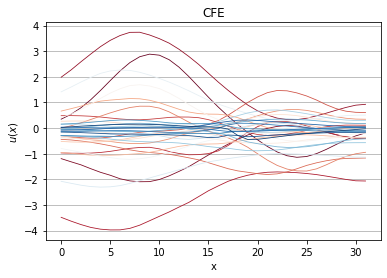

In [16]:
states = cfe_app.infer_all_frames(test_range)

bplt.burgers_figure('CFE')
for frame in range(0, step_count+1):
    plt.plot(states[frame].burgers.velocity.data[0,:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)

## Comparison

In [17]:
from burgers_fixed_set import BurgersFixedSetEnv

At first, we create a new environment with a fixed data set.

In [28]:
fixed_set_env = BurgersFixedSetEnv(
    data_path=data_path,
    data_range=test_range,
    num_envs=1,
    step_count=step_count,
    domain=domain,
    dt=dt,
    viscosity=viscosity,
    diffusion_substeps=diffusion_substeps,
    final_reward_factor=final_reward_factor,
    test_mode=True,
)

{'num_envs': 1, 'step_count': 32, 'domain': ([32], size=[1.]), 'dt': 0.03, 'viscosity': 0.003, 'diffusion_substeps': 4, 'final_reward_factor': 32}
(100, 33, 1, 32, 1)


Next, we load the previously stored PPO agent using the new fixed set environment

In [29]:
agent = PPO.load(agent_path, fixed_set_env, **ppo_kwargs)

So how about a face-to-face comparison between CFE, RL, GT and the uncontrolled simulation?

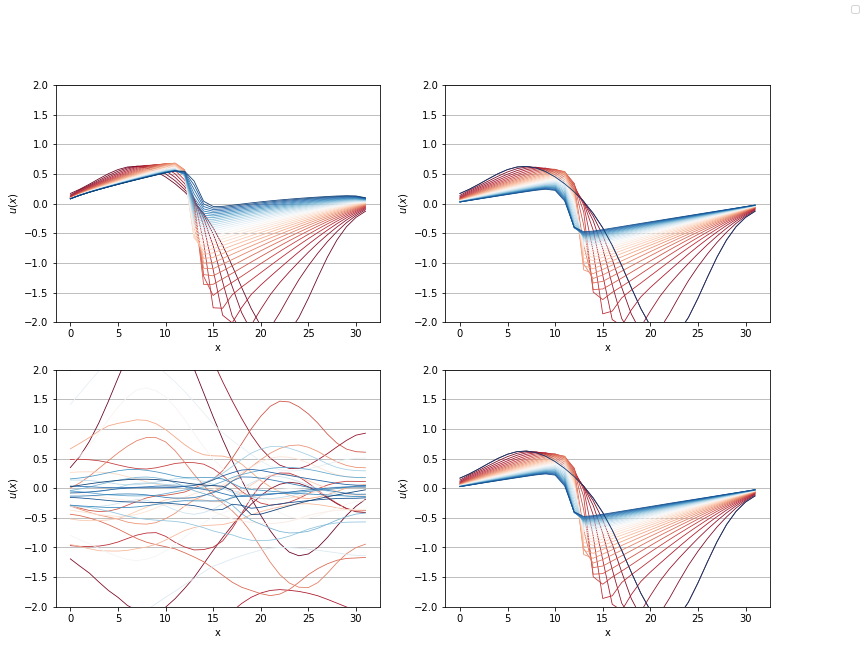

In [59]:
index_in_set = 10

fixed_set_env.dataset_idx = index_in_set
test_set = Dataset.load(data_path, test_range)

cfe_frames = np.array([f.burgers.velocity.data[0] for f in cfe_app.infer_all_frames(test_range)])
gt_frames = np.array(test_set.sources[index_in_set].scene.read_sim_frames(['burgers_velocity'], range(step_count+1))).squeeze(0)

obs = fixed_set_env.reset()

rl_frames = [obs[0]]
pass_frames = [fixed_set_env.pass_state.velocity.data.squeeze(0)]


fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.6))

for idx in [(0, 0), (0, 1), (1, 0), (1, 1)]:    
    axs[idx].set_ylabel("$u(x)$")
    axs[idx].set_xlabel("x")
    axs[idx].grid(True, axis='y')
    axs[idx].set_ylim(-2, 2)

fig.legend(['Initial state in dark red, final state in dark blue.'])

    
for _ in range(step_count):
    act, _ = agent.predict(obs, deterministic=True)
    obs, _, _, _ = fixed_set_env.step(act)
    rl_frames.append(obs[0])
    pass_frames.append(fixed_set_env.pass_state.velocity.data.squeeze(0))

for frame in range(step_count + 1):
    color = bplt.gradient_color(frame, step_count+1)
    axs[0, 0].plot(gt_frames[frame].squeeze(), color=color, linewidth=0.8)
    axs[0, 1].plot(pass_frames[frame].squeeze(), color=color, linewidth=0.8)
    axs[1, 0].plot(cfe_frames[frame].squeeze(), color=color, linewidth=0.8)
    axs[1, 1].plot(rl_frames[frame][:,0], color=color, linewidth=0.8)
